In [3]:
import ECGDataset 
import Models 
import Net
from train_test_validat import *
from self_attention import *
import matplotlib.pyplot as plt
import ecg_plot

import torch
import torch.utils.data as Data
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
import random
import pandas as pd

import time
import math
import os
import gc
import random


import sys
import logger


from torch.utils.tensorboard import SummaryWriter

class FocalLoss(nn.Module):
    r"""
        This criterion is a implemenation of Focal Loss, which is proposed in 
        Focal Loss for Dense Object Detection.

            Loss(x, class) = - \alpha (1-softmax(x)[class])^gamma \log(softmax(x)[class])

        The losses are averaged across observations for each minibatch.

        Args:
            alpha(1D Tensor, Variable) : the scalar factor for this criterion
            gamma(float, double) : gamma > 0; reduces the relative loss for well-classiﬁed examples (p > .5), 
                                   putting more focus on hard, misclassiﬁed examples
            size_average(bool): By default, the losses are averaged over observations for each minibatch.
                                However, if the field size_average is set to False, the losses are
                                instead summed for each minibatch.


    """
    def __init__(self, class_num, alpha=None, gamma=2, size_average=True):
        super(FocalLoss, self).__init__()
        if alpha is None:
            self.alpha = Variable(torch.ones(class_num, 1)).float()
        else:
            if isinstance(alpha, Variable):
                self.alpha = alpha
            else:
                self.alpha = Variable(alpha)
        self.gamma = gamma
        self.class_num = class_num
        self.size_average = size_average

    def forward(self, inputs, targets):
        # inputs = inputs.float()
        # # targets = targets.float()
        # inputs = torch.sigmoid(inputs)
        N = inputs.size(0)
        C = inputs.size(1)
        ##替代 P = F.softmax(inputs,dim=-1)，防止溢出
        log_pt = F.log_softmax(inputs, dim=-1)  # 这里相当于 CE loss
        P = torch.exp(log_pt)  # 通过 softmax 函数后打的分
 
        class_mask = inputs.data.new(N, C).fill_(0)
        class_mask = Variable(class_mask)
        ids = targets.view(-1, 1)
        class_mask.scatter_(1, ids.data, 1.)
        #print(class_mask)


        if inputs.is_cuda and not self.alpha.is_cuda:
            self.alpha = self.alpha.cuda()
        alpha = self.alpha[ids.data.view(-1)]

        probs = (P*class_mask).sum(1).view(-1,1)

        log_p = probs.log()
        #print('probs size= {}'.format(probs.size()))
        #print(probs)

        batch_loss = -alpha*(torch.pow((1-probs), self.gamma))*log_p 
        #print('-----bacth_loss------')
        #print(batch_loss)


        if self.size_average:
            loss = batch_loss.mean()
        else:
            loss = batch_loss.sum()
        return loss


time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime()) 
model_path = './model/'+time_str
log_path = './logs/'+  time_str

EcgChannles_num = 12
EcgLength_num = 5000
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

BATCH_SIZE = 160

FOLDS = 5
EPOCHS = 100  
PATIENCE = 10
LR = 0.01

if __name__ == '__main__':
    
    ALLDataset = ECGDataset.ECG_Dataset_Init('/workspace/data/Preprocess_HTN/data_like_pxl/',rebuild_flage= False,filter_age = 0)
    ALLDataset.report()  # type: ignore
    
    torch.cuda.empty_cache()# 清空显卡cuda
    # NET = [Net.MLBFNet(True,res = True,se = True,Dropout_rate = 0.25),
    #        Net.MLBFNet(True,res = True,se = True,Dropout_rate = 0.25),
    #        Net.MLBFNet(True,res = True,se = True,Dropout_rate = 0.25),
    #        Net.MLBFNet(True,res = True,se = True,Dropout_rate = 0.25),
    #        Net.MLBFNet(True,res = True,se = True,Dropout_rate = 0.25)] # type: ignore
    test_dataset = ECGDataset.ECG_Dataset(ALLDataset.testECGs,ALLDataset.testLabels,ALLDataset.testDf,preprocess= False,onehot_lable = False)  # type: ignore
    os.makedirs(model_path, exist_ok=True)  # type: ignore
    writer = SummaryWriter(log_path)  # type: ignore
    # writer.add_graph(NET[0], torch.zeros((1,12,5000)))  #模型及模型输入数据
    sys.stdout = logger.Logger(log_path+'/log.txt')
    torch.cuda.empty_cache()# 清空显卡cuda
    skf = StratifiedKFold(n_splits=FOLDS, random_state=None, shuffle=True)
    fold = 0

    train_loss_sum =[0]*FOLDS
    train_acc_sum = [0]*FOLDS
    validate_loss_sum = [0]*FOLDS
    validate_acc_sum = [0]*FOLDS
    test_loss_sum = [0]*FOLDS
    test_acc_sum = [0]*FOLDS


    print('\nTraining..\n')


cuda:0
              HTN        NHTN   
   nums       1871      103183  


            orginal            QC         
   nums      105054          65944        
              HTN        NHTN   
   nums       1344      64600   


            orginal   filtered department 
   nums      65944           13953        
              HTN        NHTN   
   nums       1344      12609   


            orginal     removed ages NaN  
   nums      13953           13953        
              HTN        NHTN   
   nums       1344      12609   
              HTN        NHTN   
   nums       1344      12609   


            orginal   removed diagnose NaN
   nums      13953           13949        
              HTN        NHTN   
   nums       1344      12605   


              HTN        NHTN   
   ALL        1344      12605   
 testset      346        5245   
 T&V set      998        7360   
              HTN        NHTN   
 TestSet      346        5245   
  TVSet       998        7360   
   ALL      


Training..



In [5]:
from scipy.signal import butter, lfilter

In [4]:
filter_lowcut = 1.0
filter_highcut = 47.0
filter_order = 1

In [6]:

def bandpass_filter(data, lowcut, highcut, signal_freq, filter_order):
        """
        Method responsible for creating and applying Butterworth filter.
        :param deque data: raw data
        :param float lowcut: filter lowcut frequency value
        :param float highcut: filter highcut frequency value
        :param int signal_freq: signal frequency in samples per second (Hz)
        :param int filter_order: filter order
        :return array: filtered data
        """
        nyquist_freq = 0.5 * signal_freq
        low = lowcut / nyquist_freq
        high = highcut / nyquist_freq
        b, a = butter(filter_order, [low, high], btype="band")
        y = lfilter(b, a, data)
        return y

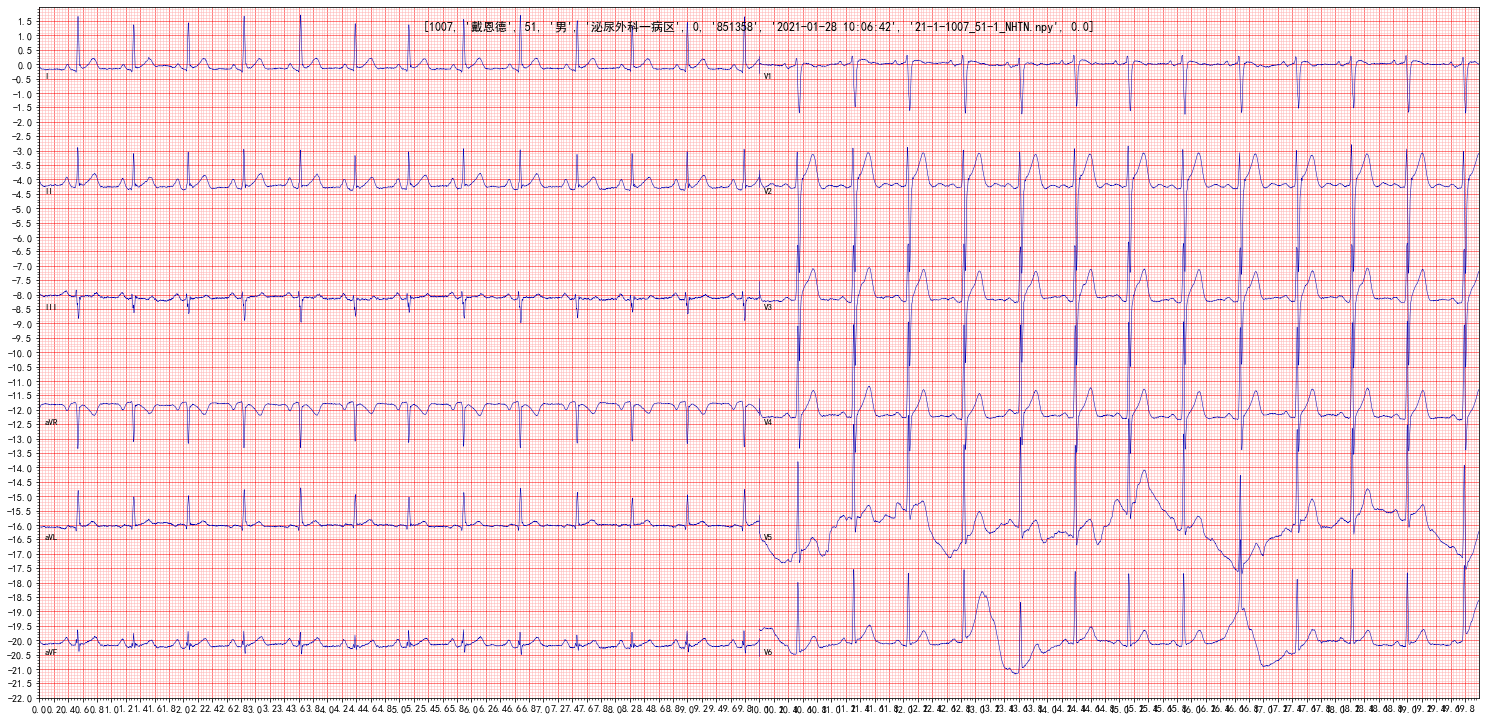

In [12]:
X,Y = test_dataset.__getitem__(0)
ecg_plot.plot(X/100,500,(test_dataset.info(0)).tolist(),columns=2,row_height= 8,show_grid=True,show_separate_line=True)  # type: ignore

In [13]:
X_filtet = bandpass_filter(X, lowcut=filter_lowcut, highcut=filter_highcut, signal_freq=500, filter_order=filter_order)# type: ignore  

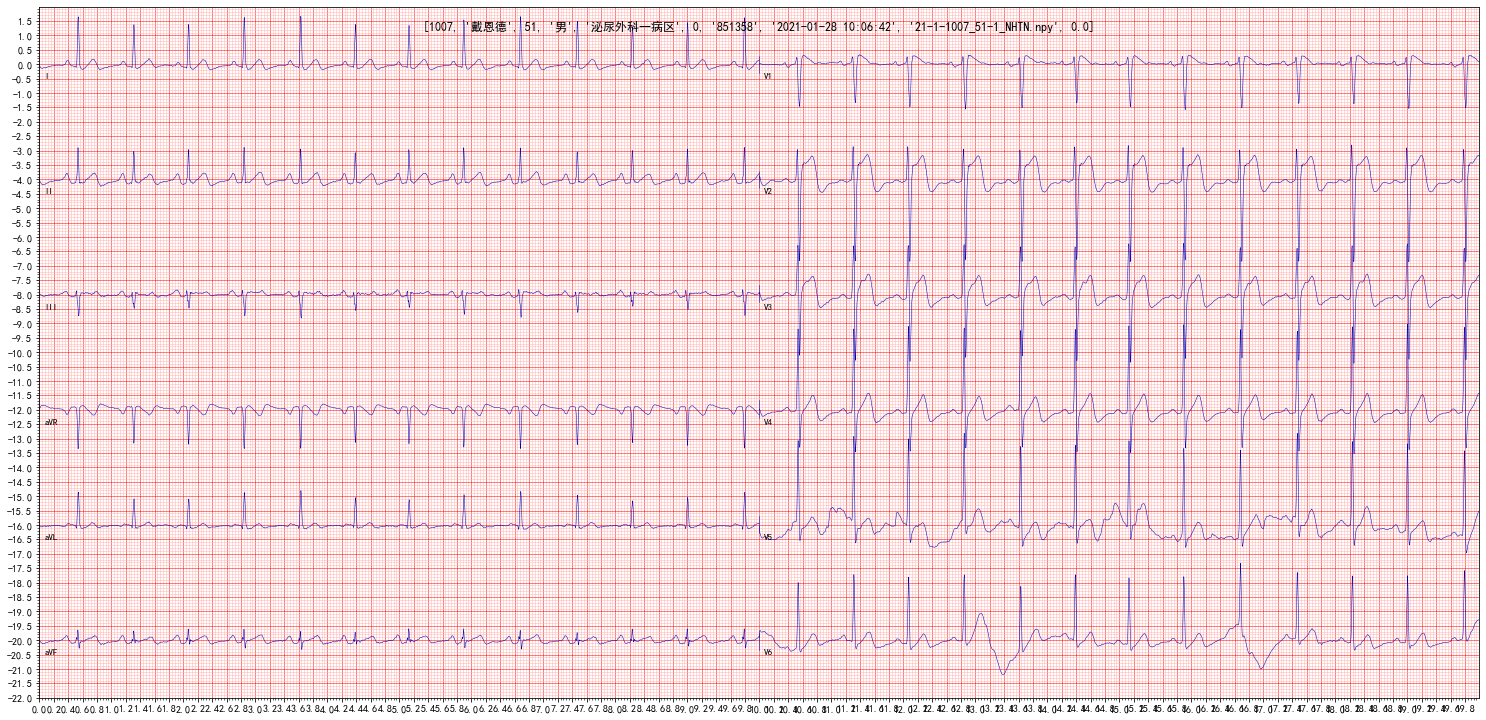

In [14]:
ecg_plot.plot(X_filtet/100,500,(test_dataset.info(0)).tolist(),columns=2,row_height= 8,show_grid=True,show_separate_line=True)  # type: ignore